In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.3 MB/s eta 0:00:00


In [ ]:
import torch
import diffusers

In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)

cuda


# Stable Diffusion from Module: v1.4

## Noise Scheduler
Stable Diffusion version 1.4 uses PNDMScheduler


In [ ]:
from diffusers import PNDMScheduler

scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "scheduler")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

## AutoEncoderKL
Convert an image of shape (3,512,512) to latent of (4,64,64)

Encoder: 4 layer of DownEncoderBlock2D
Decoder: 4 layer of UpDecoderBlock2D

Why SD Use LDM? Less memory and speed up of speed generation

In [ ]:
from torchvision import transforms as tfms
from diffusers import AutoencoderKL

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae = vae.to(torch_device)

# Convert PIL image to latents

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling from [0,1] of PIL to [-1,1] is necessary
    return 0.18215 * latent.latent_dist.sample() #put to the range used by Stable Diffusion


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

## Unet
Contains:
- encoder(12 blocks)
- a middle block
- skip connected decoder(12 blocks).

In these 25 blocks, 8 blocks are down sampling or upsampling convolution layer and 17 blocks are main blocks that each contain four resnet layers and two Vision Transformers(ViTs)

In [ ]:
from diffusers import UNet2DConditionModel
unet_conditional = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet_conditional = unet_conditional.to(torch_device)

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Text Encoder
CLIP Text Encoder for an already trained encoder

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# To the GPU
text_encoder = text_encoder.to(torch_device)

prompt = 'An astronaut riding a horse'
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
print(input_ids)

tensor([[49406,   550, 18376,  6765,   320,  4558, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]], device='cuda:0')


## Putting it all together in a pipeline

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet_conditional,
    scheduler=scheduler,
    safety_checker=None,  # or specify a safety checker
    feature_extractor=None  # or specify a feature extractor
)

pipe = pipe.to(torch_device)

# Define the prompt
prompt = "A horse riding a roller coaster"

# Generate the image
with torch.no_grad():
    image = pipe(prompt).images[0]

# Save or display the image
image.save("output.png")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

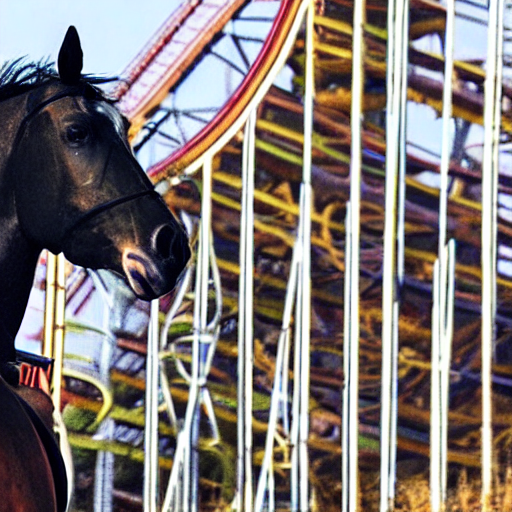

In [ ]:
image

# Stable Diffusion 2

## Noise Scheduler
DDIM Scheduler

In [ ]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("stabilityai/stable-diffusion-2", subfolder = "scheduler")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

## VAE
AutoEncoderKL

In [ ]:
from torchvision import transforms as tfms
from diffusers import AutoencoderKL

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2", subfolder="vae")

vae = vae.to(torch_device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

## Unet
Trained with bigger datasets

In [ ]:
from diffusers import UNet2DConditionModel
unet_conditional = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2", subfolder="unet")
unet_conditional = unet_conditional.to(torch_device)

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

## Text encoder
Change from OpenAI Clip to OpenCLIP

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2", subfolder = "tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2", subfolder = "text_encoder")

# To the GPU
text_encoder = text_encoder.to(torch_device)

prompt = 'An astronaut riding a horse'
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

## Putting it all together in a pipeline

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

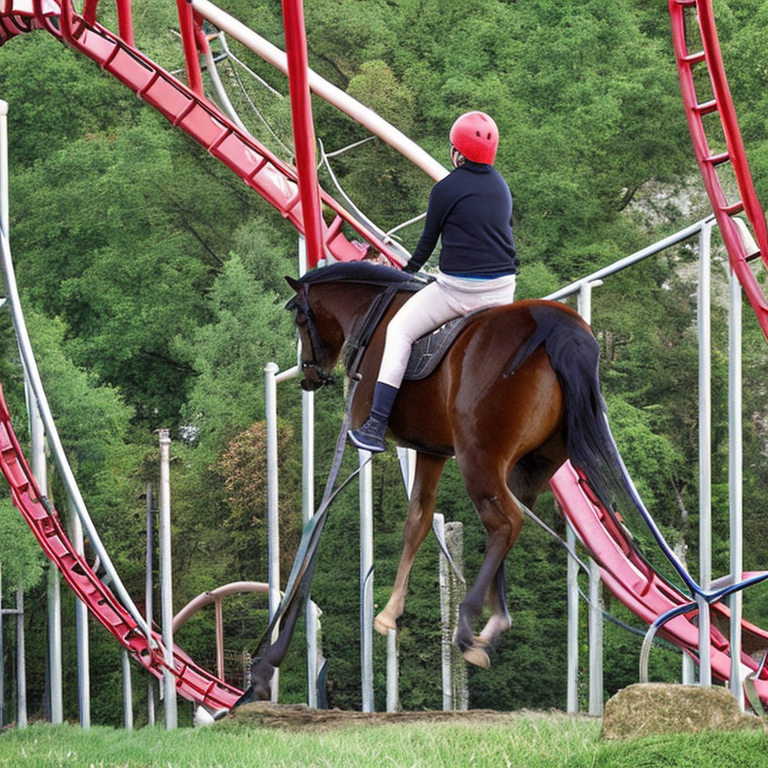

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet_conditional,
    scheduler=scheduler,
    safety_checker=None,  # or specify a safety checker
    feature_extractor=None  # or specify a feature extractor
)

pipe = pipe.to(torch_device)

# Define the prompt
prompt = "A horse riding a roller coaster"

# Generate the image
with torch.no_grad():
    image = pipe(prompt).images[0]

# Save or display the image
image

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

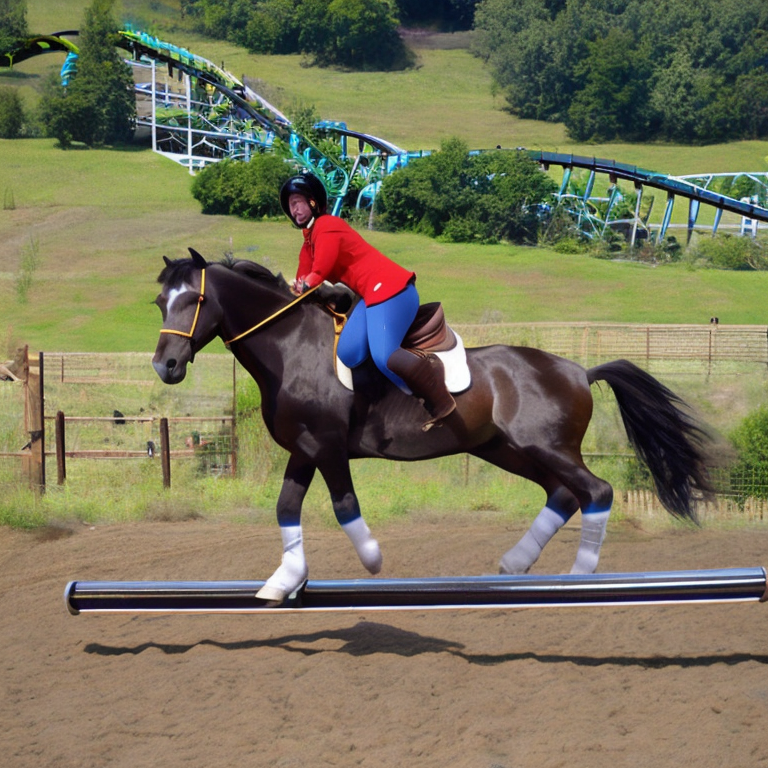

In [ ]:
# Try using other schedulers
from diffusers import PNDMScheduler

scheduler_from_sd1 = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "scheduler")
custom_pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet_conditional,
    scheduler=scheduler_from_sd1,
    safety_checker=None,  # or specify a safety checker
    feature_extractor=None  # or specify a feature extractor
)

custom_pipe = custom_pipe.to(torch_device)

# Define the prompt
prompt = "A horse riding a roller coaster"

# Generate the image
with torch.no_grad():
    image = pipe(prompt).images[0]

# Save or display the image
image

# Finetuning for LoRA
Lora Finetuning right now only supports on the UNetConditional2D